In [1]:
%cd /home/yokoyama/research
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

sys.path.append(".")
from modules.utils.video import Capture, Writer
from modules.pose import PoseDataHandler


/raid6/home/yokoyama/research


In [2]:
from submodules.i3d.pytorch_i3d import InceptionI3d
from torchvision.ops import roi_align


In [3]:
video_num = 1
cap = Capture(f"/raid6/home/yokoyama/datasets/dataset01/train/{video_num:02d}.mp4")
pose_data = PoseDataHandler.load(f"data/dataset01/train/{video_num:02d}", ["bbox"])
flows_raw = np.load("data/dataset01/train/01/bin/flow.npy")


In [4]:
flows_raw.shape


(5400, 940, 1280, 2)

In [5]:
def load_frames(cap, resize_ratio):
    frames = []
    for i in tqdm(range(cap.frame_count), ncols=100):
        frame = cap.read()[1]
        if resize_ratio != 1.0:
            frame = cv2.resize(frame, None, fx=resize_ratio, fy=resize_ratio)
        frames.append((frame / 255.) * 2 - 1)

    return frames

def resize_flows(flows, resize_ratio):
    if resize_ratio != 1.0:
        flows_resized = []
        for flow in tqdm(flows, ncols=100):
            flows_resized.append(cv2.resize(flow, None, fx=resize_ratio, fy=resize_ratio))
        return flows_resized
    else:
        return flows

resize_ratio = 0.25
frames_raw = load_frames(cap, resize_ratio)
flows_raw = resize_flows(flows_raw, resize_ratio)


  0%|                                                                      | 0/5400 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████| 5400/5400 [00:12<00:00, 426.75it/s]


In [6]:
def create_batch(frames, flows, start_frame_nums, length):
    batches_frame = []
    batches_flow = []
    for start in tqdm(start_frame_nums):
        batches_frame.append(frames[start:start + length])
        batches_flow.append(flows[start:start + length])
    return np.array(batches_frame, dtype=np.float32), np.array(batches_flow, dtype=np.float32)


batch_num = 32
frame_length = 20
start_frame_num = 1360
# start_frame_nums = sorted(np.random.choice(cap.frame_count, batch_num, replace=True) + start_frame_num)
start_frame_nums = sorted(np.random.choice(64, batch_num, replace=False) + start_frame_num)
frames, flows = create_batch(frames_raw, flows_raw, start_frame_nums, frame_length)
print(start_frame_nums)


100%|██████████| 32/32 [00:00<00:00, 269513.51it/s]


[1364, 1365, 1366, 1367, 1368, 1371, 1376, 1378, 1381, 1383, 1385, 1388, 1390, 1391, 1394, 1395, 1396, 1397, 1398, 1399, 1401, 1403, 1405, 1408, 1409, 1410, 1412, 1413, 1414, 1415, 1421, 1422]


In [7]:
del frames_raw, flows_raw


In [8]:
frames = torch.Tensor(frames)
frames = torch.permute(frames, (0, 4, 1, 2, 3))

flows = torch.Tensor(flows)
flows = torch.permute(flows, (0, 4, 1, 2, 3))

frames.shape


torch.Size([32, 3, 20, 235, 320])

In [9]:
# model_path_frame = "submodules/i3d/models/rgb_imagenet.pt"
# model_path_frame = "submodules/i3d/models/rgb_charades.pt"
i3d_frame = InceptionI3d(in_channels=3, final_endpoint="Mixed_3c")
i3d_frame.build()
# i3d.cuda(1)
# i3d_frame.replace_logits(157)
# i3d_frame.load_state_dict(torch.load(model_path_frame))

# model_path_flow = "submodules/i3d/models/flow_imagenet.pt"
# model_path_flow = "submodules/i3d/models/flow_charades.pt"
i3d_flow = InceptionI3d(in_channels=2, final_endpoint="Mixed_3c")
i3d_flow.build()
# i3d.cuda(1)
# i3d_flow.replace_logits(157)
# i3d_flow.load_state_dict(torch.load(model_path_flow))

# i3d = InceptionI3d(in_channels=in_channels, final_endpoint="Mixed_3b")
# i3d.build()
# i3d.cuda(1)
print("done")


done


In [10]:
# feature = i3d.extract_features(tensor)
x = frames
for end_point in i3d_frame.VALID_ENDPOINTS:
    if end_point in i3d_frame.end_points:
        x = i3d_frame._modules[end_point](x)
    # if end_point == "Mixed_3c":
    #     break
# x = i3d_frame.avg_pool(x)

feature_frame = x.cpu()
feature_frame.shape


torch.Size([32, 480, 10, 30, 40])

In [11]:
# feature = i3d.extract_features(tensor)
x = flows
for end_point in i3d_flow.VALID_ENDPOINTS:
    if end_point in i3d_flow.end_points:
        x = i3d_flow._modules[end_point](x)
    # if end_point == "Mixed_3c":
    #     break
# x = i3d_flow.avg_pool(x)

feature_flow = x.cpu()
feature_flow.shape


torch.Size([32, 480, 10, 30, 40])

In [12]:
feature = feature_frame + feature_flow
# feature = feature_frame
# feature = feature_flow
feature = feature[:, :, -1]
feature.shape


torch.Size([32, 480, 30, 40])

In [13]:
h, w = frames.shape[3:5]
fy, fx = feature.shape[2:4]
fx / w


0.125

In [14]:
bboxs_all = []
for start_frame_num in start_frame_nums:
    pose_data_frame = [
        data for data in pose_data
        if data["frame"] == start_frame_num + frame_length // 2 + 1
    ]

    bboxs = [np.array(data["bbox"]).reshape(2, 2) * resize_ratio for data in pose_data_frame]

    bboxs = torch.Tensor(np.array(bboxs))
    bboxs *= torch.Tensor((fx / w, fy / h))

    bboxs_all.append(bboxs.reshape(-1, 4))

output_size = 5
feature_aligned = roi_align(feature, bboxs_all, output_size, spatial_scale=fx / w, aligned=True)
feature_aligned = feature_aligned.detach().numpy()

feature_aligned.shape


(192, 480, 5, 5)

In [15]:
feature_aligned[0, 0]


array([[0.6276145 , 0.64399195, 0.66036934, 0.6767467 , 0.6931242 ],
       [0.7614604 , 0.7754118 , 0.78936327, 0.8033147 , 0.817266  ],
       [0.89530635, 0.90683174, 0.91835713, 0.9298825 , 0.9414079 ],
       [0.982766  , 0.9889298 , 0.9950937 , 1.0012577 , 1.0074215 ],
       [0.92329663, 0.91480076, 0.90630484, 0.897809  , 0.8893131 ]],
      dtype=float32)

In [16]:
pids_all_batch = [
    [
        data["id"] for data in pose_data
        if data["frame"] == start_frame_num + frame_length // 2 + 1
    ]
    for start_frame_num in start_frame_nums
]


In [17]:
ch = feature_aligned.shape[1]
n_components = 2
features_aligned_all = feature_aligned.reshape(-1, ch * output_size**2)
pca = PCA(n_components=n_components)
pca.fit(features_aligned_all)

embedding_dict = {}
tail_idx = 0
for pid_batch, start_frame_num in zip(pids_all_batch, start_frame_nums):
    data_num = len(pid_batch)
    # pca = PCA(n_components=2)
    # pca.fit(feature_aligned[tail_idx: tail_idx + data_num].reshape(-1, 256 * 2 * 2))
    for i, pid in enumerate(pid_batch):
        features = feature_aligned[i + tail_idx]
        embedding = pca.transform(features.reshape(-1, ch * output_size**2))

        if pid not in embedding_dict:
            embedding_dict[pid] = np.empty((0, n_components + 1))
        embedding = np.append(embedding, start_frame_num)
        embedding_dict[pid] = np.append(embedding_dict[pid], [embedding], axis=0)

    tail_idx += data_num


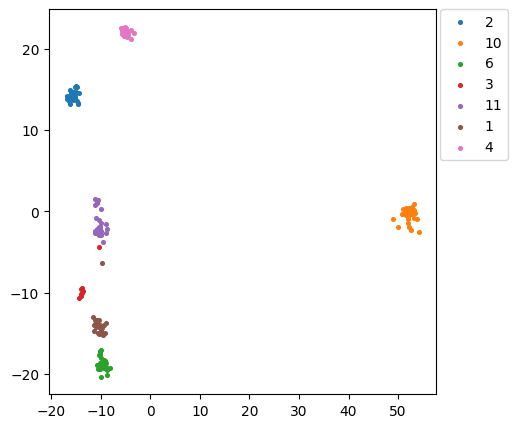

In [18]:
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
for i, (pid, embedding) in enumerate(embedding_dict.items()):
    # if i not in range(15, 20):
    #     continue
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=7, label=pid
    )
    # if pid == 10:
    #     for j in range(len(embedding)):
    #         plt.text(embedding[j, 0], embedding[j, 1], pid)
    # for j in range(len(embedding)):
    #     if embedding[j, n_components] in start_frame_nums[::batch_num - 1]:
    #         plt.text(embedding[j, 0], embedding[j, 1], int(embedding[j, 2]))

# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(pids)
# plt.xlim((-10, 30))
# plt.ylim((-20, 20))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()


In [18]:
features_aligned_all = feature_aligned.reshape(-1, ch * output_size**2)
um = umap.UMAP(n_neighbors=6, n_components=n_components, random_state=64)
um.fit(features_aligned_all)
# pca = PCA(n_components=2)
# pca.fit(features_aligned_all)

embedding_dict = {}
tail_idx = 0
for pid_batch, start_frame_num in zip(pids_all_batch, start_frame_nums):
    data_num = len(pid_batch)
    # pca = PCA(n_components=2)
    # pca.fit(feature_aligned[tail_idx: tail_idx + data_num].reshape(-1, 256 * 2 * 2))
    for i, pid in enumerate(pid_batch):
        features = feature_aligned[i + tail_idx]
        embedding = um.transform(features.reshape(-1, ch * output_size**2))
        # embedding = pca.transform(features.reshape(-1, 256 * output_size**2))

        if pid not in embedding_dict:
            embedding_dict[pid] = np.empty((0, n_components + 1))
        embedding = np.append(embedding, start_frame_num)
        embedding_dict[pid] = np.append(embedding_dict[pid], [embedding], axis=0)

    tail_idx += data_num


In [19]:
print(start_frame_nums)


[1362, 1366, 1371, 1372, 1373, 1376, 1377, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1389, 1390, 1391, 1394, 1395, 1396, 1398, 1399, 1405, 1406, 1409, 1411, 1414, 1417, 1419, 1420, 1422, 1423]


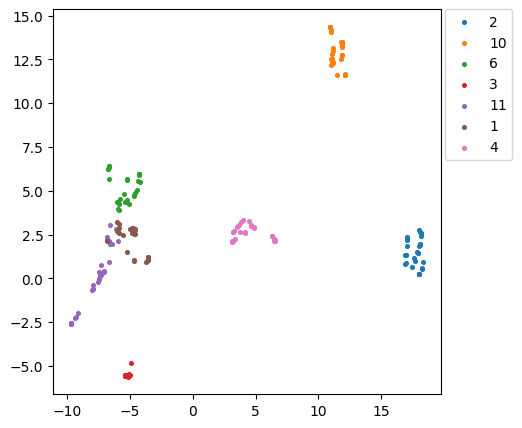

In [20]:
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
for i, (pid, embedding) in enumerate(embedding_dict.items()):
    # if i not in range(15, 20):
    #     continue
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=7, label=pid
    )
    # for j in range(len(embedding)):
    #     if embedding[j, 2] in start_frame_nums[::batch_num - 1]:
    #         plt.text(embedding[j, 0], embedding[j, 1], int(embedding[j, 2]))

# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(pids)
# plt.xlim((-20, 10))
# plt.ylim((-10, 10))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()
